In [8]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import rmse
import plotnine as p9
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error



In [ ]:
df = pd.read_parquet(r'C:\Users\João Pedro\Desktop\previsao_vendas\dados\gold\vendas_modelo.parquet')

print(df.head())

15:57:56 - cmdstanpy - INFO - Chain [1] start processing
15:57:57 - cmdstanpy - INFO - Chain [1] done processing


RMSE de treino: 134.60645364543552
RMSE de teste: 160.32544779302378
MAPE de treino: 63.06 %
MAPE de teste: 101.78 %
            ds        yhat
716 2024-12-17  268.676431
717 2024-12-18  276.412518
718 2024-12-19  273.015459
719 2024-12-20  272.976959
720 2024-12-21  318.371867
721 2024-12-22  337.648547
722 2024-12-23  291.927722
723 2024-12-24  268.644875
724 2024-12-25  276.380962
725 2024-12-26  272.983903
726 2024-12-27  272.945403
727 2024-12-28  318.340311
728 2024-12-29  337.616991
729 2024-12-30  291.896166


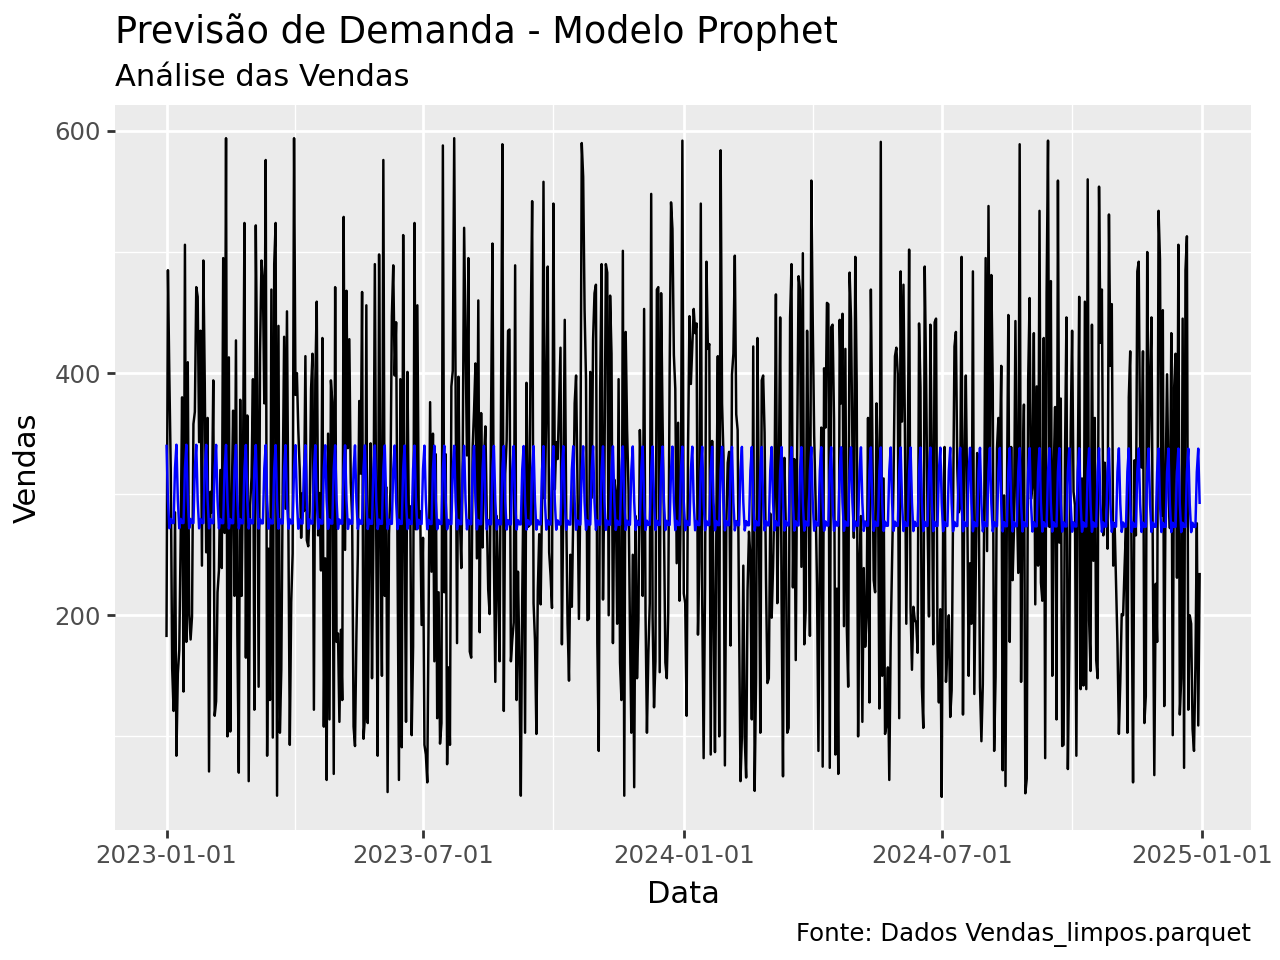

In [15]:
#Preparar base para o Prophet 
df_Ps = (
    df
    .assign(data=pd.to_datetime(df['data']))
    .rename(columns={'data': 'ds', 'vendas': 'y'})
    .sort_values('ds')
)

#Separar treino e teste (últimos 14 dias)
y_treino = df_Ps.iloc[:-14].reset_index(drop=True)
y_teste = df_Ps.iloc[-14:].reset_index(drop=True)

#Treinar modelo 
modelo = Prophet()
modelo.fit(y_treino)

#Criar dataframe de datas futuras (mesmo tamanho treino+teste)
future = modelo.make_future_dataframe(periods=14, freq='D')
previsoes = modelo.predict(future)

#Calcular métricas de erro 
rmse_treino = np.sqrt(
    mean_squared_error(
        y_treino['y'], previsoes.loc[:len(y_treino)-1, 'yhat']
    )
)
rmse_teste = np.sqrt(
    mean_squared_error(
        y_teste['y'], previsoes.tail(14)['yhat']
    )
)

print('RMSE de treino:', rmse_treino)
print('RMSE de teste:', rmse_teste)

# Calcular MAPE
mape_treino = mean_absolute_percentage_error(
    y_treino['y'], previsoes.loc[:len(y_treino)-1, 'yhat']
)
mape_teste = mean_absolute_percentage_error(
    y_teste['y'], previsoes.tail(14)['yhat']
)

print('MAPE de treino:', round(mape_treino*100,2), '%')
print('MAPE de teste:', round(mape_teste*100,2), '%')

# Juntar dados reais e previstos para plotar
resultados = (
    df_Ps
    .merge(previsoes[['ds', 'yhat']], on='ds', how='right')
)

# Filtrar para mostrar apenas as previsões dos 14 dias futuros
previsao_14_dias = previsoes.tail(14)[['ds', 'yhat']]

# Exibir a tabela de resultados (previsões para os próximos 14 dias)
print(previsao_14_dias)

#Plot com plotnine 
(
    p9.ggplot(resultados)
    + p9.aes(x='ds', y='y')
    + p9.geom_line(color='black')                
    + p9.geom_line(p9.aes(y='yhat'), color='blue')  
    + p9.labs(
        title="Previsão de Demanda - Modelo Prophet",
        subtitle="Análise das Vendas",
        x="Data",
        y="Vendas",
        caption="Fonte: Dados Vendas_limpos.parquet"
    )
)
